# 스프린트 미션 08

- U-Net을 이용해 축구 경기 영상 내의 다양한 객체(예: 골대, 심판, 선수, 관중 등)를 픽셀 단위로 분할하는 Semantic Segmentation 작업을 수행

- 실제 경기 장면에서 추출한 이미지를 바탕으로, 각 픽셀이 어떤 클래스에 속하는지 예측하는 모델을 직접 설계하고 학습

11개 클래스

- Goal Bar (골대)  
- Referee (심판)  
- Advertisement (광고판)  
- Ground (잔디)  
- Ball (축구공)  
- Coaches & Officials (코칭 스태프 및 심판진)  
- Audience (관중)  
- Goalkeeper A (팀 A 골키퍼)  
- Goalkeeper B (팀 B 골키퍼)  
- Team A (팀 A 선수)  
- Team B (팀 B 선수)  

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.v2 as v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import TensorDataset
import pycocotools

In [ ]:
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib
!pip install scikit-image
!pip install torchmetrics
!pip install pycocotools
!pip install faster-coco-eval
!pip install torchmetrics[detection]
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# 이미지 파일 압축 해제

import zipfile

zip_path = "./archive_08.zip"
extract_path = "./08"

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("압축 해제 완료!")

압축 해제 완료!


## 이미지 파일 불러오기

In [ ]:
# 이미지 파일을 original / fuse / save 폴더를 만들고 확장자 별로 정리


import shutil

base_dir = './08/images'
original_dir = os.path.join(base_dir, 'original')
fuse_dir = os.path.join(base_dir, 'fuse')
save_dir = os.path.join(base_dir, 'save')

# 폴더 없으면 생성
os.makedirs(original_dir, exist_ok=True)
os.makedirs(fuse_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

for filename in os.listdir(base_dir):
    src_path = os.path.join(base_dir, filename)

    # 디렉토리 무시
    if os.path.isdir(src_path):
        continue

    if filename.endswith('.jpg') and '___' not in filename:
        shutil.move(src_path, os.path.join(original_dir, filename))
    elif '___fuse' in filename:
        shutil.move(src_path, os.path.join(fuse_dir, filename))
    elif '___save' in filename:
        shutil.move(src_path, os.path.join(save_dir, filename))

In [ ]:
# 원본 이미지 파일 형식 확인

img = Image.open('08/images/original/Frame 1  (1).jpg')
print(f"original 이미지 형식 : {img.mode}")
img = Image.open('08/images/fuse/Frame 1  (1).jpg___fuse.png')
print(f"fuse 이미지 형식 : {img.mode}")
img = Image.open('08/images/save/Frame 1  (1).jpg___save.png')
print(f"save 이미지 형식 : {img.mode}")

original 이미지 형식 : RGB
fuse 이미지 형식 : RGBA
save 이미지 형식 : RGBA


- RGBA : mask.size = (H, W, 4) ← 알파 채널(투명도) 포함

In [ ]:
# 각 폴더 이미지 개수 확인

from PIL import Image
import os

def load_images_as_pil(image_dir):
    image_list = []
    filenames = sorted(os.listdir(image_dir))

    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(image_dir, filename)
            img = Image.open(path).convert('RGB')
            image_list.append(img)

    return image_list

# 예시
original_images = load_images_as_pil('08/images/original')
fuse_images = load_images_as_pil('08/images/fuse')
save_images = load_images_as_pil('08/images/save')

In [ ]:
print(f"original_images_count : {len(original_images)}")
print(f"original_fuse_count : {len(fuse_images)}")
print(f"original_save_count : {len(save_images)}")

original_images_count : 100
original_fuse_count : 100
original_save_count : 100


## fuse_images 처리

- 1. Gray로 전환후 클래스 목록 보기
- 2. RGB로 전환후 클래스 목록 보기

In [ ]:
# fuse(mask) 파일은 RGB 가 아닌 흑백으로 받아오기

def load_masks_as_class_labels(mask_dir):
    mask_list = []
    filenames = sorted(os.listdir(mask_dir))

    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(mask_dir, filename)
            mask = Image.open(path).convert("L")  #  RGBA → 클래스 인덱스 마스크
            mask_list.append(mask)

    return mask_list

In [ ]:
fuse_masks = load_masks_as_class_labels('08/images/fuse')

In [ ]:
# 클래스가

all_unique_ids = set()

for mask in fuse_masks:
    # PIL.Image → Tensor
    mask_tensor = TF.pil_to_tensor(mask).squeeze()  # shape: (1, H, W) → (H, W)
    unique_ids = torch.unique(mask_tensor).tolist()
    all_unique_ids.update(unique_ids)

print(" 전체 클래스 ID 목록:", sorted(all_unique_ids))

📌 전체 클래스 ID 목록: [0, 67, 80, 90, 97, 129, 170, 191, 213, 214]


- fuse_image를 Gray로 전환하고 클래스 ID 확인 시 총 10개의 클래스가 나옴
- 총 11개의 클래스가 나와야 하므로 fuse_image를 RGB로 변환하고 클래스 확인 및 매핑

In [ ]:
# fuse(images) -> RGB로 불러오기

def get_unique_colors_from_pil(pil_images, max_classes=11):
    color_set = set()

    for img in pil_images:
        # PIL.Image → NumPy (RGB)로 변환
        np_img = np.array(img)

        # 고유한 RGB 색 추출 (H*W, 3) → unique colors
        unique_colors = np.unique(np_img.reshape(-1, 3), axis=0)

        for color in unique_colors:
            color_set.add(tuple(color))

            if len(color_set) >= max_classes:
                return list(color_set)

    return list(color_set)

In [ ]:
unique_colors = get_unique_colors_from_pil(fuse_images, max_classes=11)
# 색상 → 클래스 라벨 매핑
color_to_label = {color: idx for idx, color in enumerate(unique_colors)}

print("📌 Unique Colors:", unique_colors)
print("📌 Color to Label:", color_to_label)

📌 Unique Colors: [(np.uint8(238), np.uint8(171), np.uint8(171)), (np.uint8(254), np.uint8(233), np.uint8(3)), (np.uint8(0), np.uint8(0), np.uint8(0)), (np.uint8(255), np.uint8(0), np.uint8(29)), (np.uint8(111), np.uint8(48), np.uint8(253)), (np.uint8(137), np.uint8(126), np.uint8(126)), (np.uint8(27), np.uint8(71), np.uint8(151)), (np.uint8(255), np.uint8(160), np.uint8(1)), (np.uint8(201), np.uint8(19), np.uint8(223)), (np.uint8(255), np.uint8(159), np.uint8(0)), (np.uint8(255), np.uint8(235), np.uint8(0))]
📌 Color to Label: {(np.uint8(238), np.uint8(171), np.uint8(171)): 0, (np.uint8(254), np.uint8(233), np.uint8(3)): 1, (np.uint8(0), np.uint8(0), np.uint8(0)): 2, (np.uint8(255), np.uint8(0), np.uint8(29)): 3, (np.uint8(111), np.uint8(48), np.uint8(253)): 4, (np.uint8(137), np.uint8(126), np.uint8(126)): 5, (np.uint8(27), np.uint8(71), np.uint8(151)): 6, (np.uint8(255), np.uint8(160), np.uint8(1)): 7, (np.uint8(201), np.uint8(19), np.uint8(223)): 8, (np.uint8(255), np.uint8(159), np.

- 11개의 클래스가 잘나왔고 각 클래스를 0~10으로 매핑

## 데이터 -> 데이터셋
- transform : resize (256, 448) , 평균 / 표준편차 정규화

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, original_images, fuse_images, color_to_label, transform=None):
        self.images = original_images         # list of PIL.Image
        self.masks = fuse_images              # list of PIL.Image (RGB segmentation mask)
        self.color_to_label = color_to_label  # dict: RGB tuple → class label
        self.transform = transform            # Albumentations

    def convert_rgb_to_label_mask(self, pil_img):
        np_img = np.array(pil_img)
        label_mask = np.zeros((np_img.shape[0], np_img.shape[1]), dtype=np.uint8)

        for color, label in self.color_to_label.items():
            mask = np.all(np_img == color, axis=-1)
            label_mask[mask] = label

        return label_mask

    def __getitem__(self, idx):
        image = np.array(self.images[idx])       # (H, W, 3)
        rgb_mask = self.masks[idx]               # PIL.Image

        label_mask = self.convert_rgb_to_label_mask(rgb_mask)  # (H, W), dtype=uint8

        if self.transform:
            transformed = self.transform(image=image, mask=label_mask)
            image = transformed['image']                     # Tensor
            label_mask = transformed['mask'].long()          # Tensor (long, for CE Loss)

        return image, label_mask

    def __len__(self):
        return len(self.images)

In [ ]:
dataset =  SegmentationDataset(original_images, fuse_images, color_to_label=color_to_label)

In [ ]:
# 이미지 크기 확인

unique_images = set()

train_imgs_sizes = []

for i in range(len(dataset)):
    image, _ = dataset[i]
    img_np = np.array(image)
    img_np.shape[:2]
    train_imgs_sizes.append(img_np.shape[:2])

In [ ]:
np.unique(train_imgs_sizes)

array([1080, 1920])

- 모든 이미지 사이즈는 H : 1080 / W : 1920 으로 같음
- 그러면 이미지를 어떤 사이즈로 넣는게 좋을까 생각해야함
- 이미지가 너무 크면 학습하는데 시간이 오래 걸리므로 1/4정도 크기인  256 / 448 정도로 넣을까 생각 (U-net에서도 학습시키기 좋은 size)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(height=256, width=448),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
dataset =  SegmentationDataset(original_images, fuse_images,  color_to_label=color_to_label, transform = transform)

In [ ]:
dataset[0][1]

img , mask = dataset[0]

In [ ]:
mask

tensor([[4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        [4, 4, 4,  ..., 4, 4, 4],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [ ]:
# images의 평균과 표준 편차를 구해서 평균 , 표준 편차로 정규화

channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)
num_pixels = 0

for i in range(len(dataset)):
    img, _ = dataset[i]
    img = img.float() / 255.0  # 스케일링

    channel_sum += img.sum(dim=(1, 2))
    channel_squared_sum += (img ** 2).sum(dim=(1, 2))
    num_pixels += img.shape[1] * img.shape[2]

mean = channel_sum / num_pixels
mean_of_square = channel_squared_sum / num_pixels
std = torch.sqrt(mean_of_square - mean ** 2)

print("📌 Mean:", mean)
print("📌 Std:", std)

📌 Mean: tensor([0.3466, 0.3883, 0.3317])
📌 Std: tensor([0.2120, 0.2240, 0.2122])


In [ ]:
transform = A.Compose([
    A.Resize(height=256, width=448),
    A.Normalize(mean=[0.3466, 0.3883, 0.3317], std = [0.2120, 0.2240, 0.2122]),
    ToTensorV2()
])

In [ ]:
dataset =  SegmentationDataset(original_images, fuse_images, color_to_label=color_to_label, transform = transform)

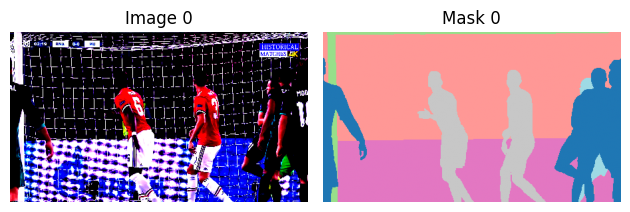

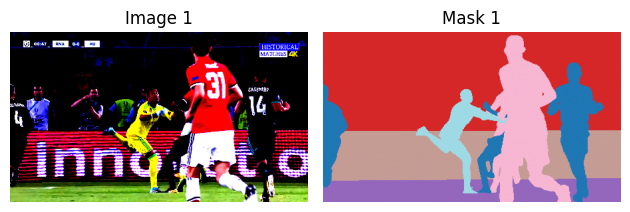

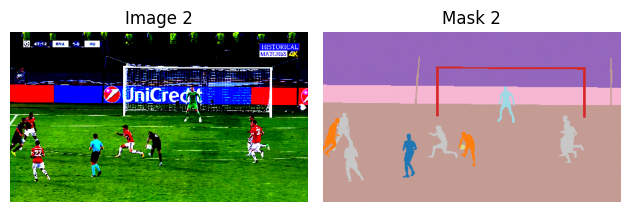

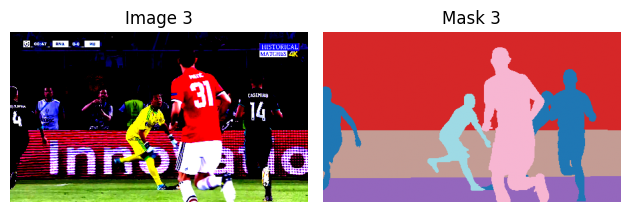

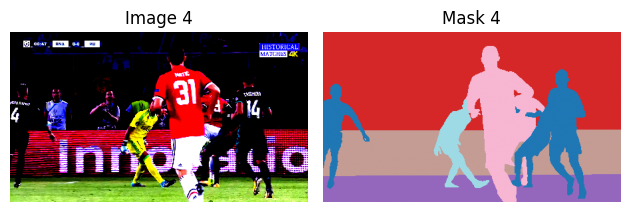

In [ ]:
# Image와 Mask가 잘 나오는지 확인

for i in range(5):
    img , mask = dataset[i]

    # 이미지 시각화

    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Image {i}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='tab20')  # or cmap='nipy_spectral' 등
    plt.title(f"Mask {i}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## 시드 고정

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = 42 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 1. 전체 시드 고정
set_seed(42)

# 2. DataLoader용 generator 생성
g = torch.Generator()
g.manual_seed(42)

## train / val 로 데이터셋 분리
- 학습할 데이터가 적으므로 최대한 학습 데이터 확보를 위해 90 / 10 으로 train / val 데이터를 나누고 val 데이터를 통해 학습 에폭마다 모델의 성능과 최종 성능을 같이 확인하는데 활용

In [ ]:
from torch.utils.data import random_split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

## dataset -> dataloader
- tran_loader batch_size = 10
- val_loader vatch_size = 10

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True,
                          worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

## 전이 학습 방법을 통한 U-net 모델 만들기

In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
import segmentation_models_pytorch as smp

## u_net_resnet34
- ResNet34를 encoder로 사용하는 U-Net 구조를 구성하고, deconvolution layer와 skip connection을 통해 segmentation 모델을 학습시키기
- 학습된 가중치 가져오기 및 전체층 학습

In [ ]:
unet_res34 = smp.Unet(
    encoder_name="resnet34",
    encoder_weights='imagenet',
    classes=11
)

In [ ]:
unet_res34

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## 평가 지표

- Dice Score :
모델의 출력에서 가장 확률이 높은 클래스를 선택한 후,
각 클래스에 대해 이진 마스크를 만들어 클래스 단위의 Dice Score를 계산하고,
전체 클래스에 대해 평균을 내어 최종 Dice Score를 구합니다.
이 점수는 클래스 간 균형을 고려한 전체 분할 성능의 지표로 활용됩니다.

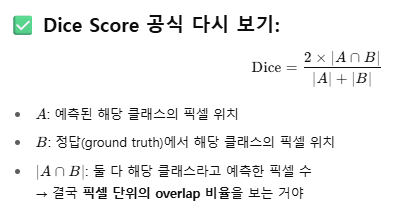

In [ ]:
# mIoU

def compute_mIoU(preds, targets, num_classes):
    ious = []
    preds = preds.view(-1)
    targets = targets.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return sum(ious) / len(ious)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # preds: [B, C, H, W] → one-hot → [B, C, H, W]
        preds = torch.softmax(preds, dim=1) #

        #원핫을 하는 이유는?
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
        #preds 와 shape 맞추기 : [B, H, W]  ->	[B, H, W, C]  -> [B, C, H, W]

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

## 학습

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_res34 = unet_res34.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_res34.parameters(), lr=0.0001)

In [ ]:
dice_loss_fn = DiceLoss()
num_epochs = 50

for epoch in range(num_epochs):
    unet_res34.train()

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = unet_res34(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    unet_res34.eval()
    total_mIoU, total_dice = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = unet_res34(imgs)
            pred_labels = preds.argmax(dim=1)

            total_mIoU += compute_mIoU(pred_labels, masks, num_classes=11)
            total_dice += 1 - dice_loss_fn(preds, masks)

    print(f"[Epoch {epoch+1}] loss: {loss:.4f}, mIoU: {total_mIoU/len(val_loader):.4f}, Dice: {total_dice/len(val_loader):.4f}")

[Epoch 1] loss: 2.0554, mIoU: 0.1117, Dice: 0.0718
[Epoch 2] loss: 1.7268, mIoU: 0.1864, Dice: 0.1004
[Epoch 3] loss: 1.5656, mIoU: 0.2227, Dice: 0.1177
[Epoch 4] loss: 1.3993, mIoU: 0.2733, Dice: 0.1254
[Epoch 5] loss: 1.3082, mIoU: 0.3081, Dice: 0.1322
[Epoch 6] loss: 1.1913, mIoU: 0.3296, Dice: 0.1411
[Epoch 7] loss: 1.1713, mIoU: 0.3425, Dice: 0.1532
[Epoch 8] loss: 1.0950, mIoU: 0.3503, Dice: 0.1598
[Epoch 9] loss: 1.0315, mIoU: 0.3598, Dice: 0.1713
[Epoch 10] loss: 1.0114, mIoU: 0.3646, Dice: 0.1818
[Epoch 11] loss: 0.8519, mIoU: 0.3717, Dice: 0.1904
[Epoch 12] loss: 0.7983, mIoU: 0.3732, Dice: 0.1967
[Epoch 13] loss: 0.7341, mIoU: 0.3808, Dice: 0.2069
[Epoch 14] loss: 0.6855, mIoU: 0.3888, Dice: 0.2108
[Epoch 15] loss: 0.6703, mIoU: 0.3946, Dice: 0.2189
[Epoch 16] loss: 0.6105, mIoU: 0.3986, Dice: 0.2257
[Epoch 17] loss: 0.5922, mIoU: 0.3954, Dice: 0.2320
[Epoch 18] loss: 0.5713, mIoU: 0.4007, Dice: 0.2395
[Epoch 19] loss: 0.5294, mIoU: 0.4034, Dice: 0.2457
[Epoch 20] loss: 0.49

KeyboardInterrupt: 

In [ ]:
# 시각화

def visualize_all_predictions(model, dataset, device='cuda', cmap='tab20'):
    model.eval()
    num_samples = min(len(dataset), 10)  # 최대 10개까지

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        img, gt_mask = dataset[i]
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_input)
            pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu()

        # 이미지 복원 (정규화했을 경우 대비)
        img_vis = img.permute(1, 2, 0).cpu().numpy()

        axes[i][0].imshow(img_vis)
        axes[i][0].set_title(f"[{i}] Input")
        axes[i][0].axis('off')

        axes[i][1].imshow(gt_mask, cmap=cmap)
        axes[i][1].set_title("Ground Truth")
        axes[i][1].axis('off')

        axes[i][2].imshow(pred_mask, cmap=cmap)
        axes[i][2].set_title("Prediction")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
visualize_all_predictions(unet_res34, val_dataset, device=device)

## u_net_efficientnet
- Efficientnet를 encoder로 사용하는 U-Net 구조를 구성하고, deconvolution layer와 skip connection을 통해 segmentation 모델을 학습시키기
- 학습된 가중치 가져오기 및 전체층 학습

In [ ]:
unet_eff = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=11
)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
unet_eff = unet_eff.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_eff.parameters(), lr=0.0001) # 0.0001

In [ ]:
dice_loss_fn = DiceLoss()
num_epochs = 50

for epoch in range(num_epochs):
    unet_eff.train()

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = unet_eff(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    unet_eff.eval()
    total_mIoU, total_dice = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = unet_eff(imgs)
            pred_labels = preds.argmax(dim=1)

            total_mIoU += compute_mIoU(pred_labels, masks, num_classes=11)
            total_dice += 1 - dice_loss_fn(preds, masks)

    print(f"[Epoch {epoch+1}] loss: {loss:.4f}, val_mIoU: {total_mIoU/len(val_loader):.4f}, val_Dice: {total_dice/len(val_loader):.4f}")

[Epoch 1] loss: 2.3502, val_mIoU: 0.0436, val_Dice: 0.0530
[Epoch 2] loss: 2.0471, val_mIoU: 0.0758, val_Dice: 0.0677
[Epoch 3] loss: 1.8909, val_mIoU: 0.1259, val_Dice: 0.0837
[Epoch 4] loss: 1.8000, val_mIoU: 0.1756, val_Dice: 0.0956
[Epoch 5] loss: 1.6211, val_mIoU: 0.2076, val_Dice: 0.1045
[Epoch 6] loss: 1.5195, val_mIoU: 0.2267, val_Dice: 0.1129
[Epoch 7] loss: 1.4183, val_mIoU: 0.2387, val_Dice: 0.1219
[Epoch 8] loss: 1.3250, val_mIoU: 0.2513, val_Dice: 0.1325
[Epoch 9] loss: 1.2295, val_mIoU: 0.2727, val_Dice: 0.1412
[Epoch 10] loss: 1.1401, val_mIoU: 0.3005, val_Dice: 0.1499
[Epoch 11] loss: 1.1331, val_mIoU: 0.3151, val_Dice: 0.1588
[Epoch 12] loss: 1.1081, val_mIoU: 0.3299, val_Dice: 0.1682
[Epoch 13] loss: 0.9445, val_mIoU: 0.3400, val_Dice: 0.1751
[Epoch 14] loss: 0.9749, val_mIoU: 0.3485, val_Dice: 0.1822
[Epoch 15] loss: 0.7883, val_mIoU: 0.3522, val_Dice: 0.1877
[Epoch 16] loss: 0.8067, val_mIoU: 0.3573, val_Dice: 0.1928
[Epoch 17] loss: 0.7339, val_mIoU: 0.3586, val_Di

In [ ]:
visualize_all_predictions(unet_eff, val_dataset, device=device)

## pretrained_resnet34(U_net) vs pretrained_efficientnet(U_net)
- resnet34(U_net) : [Epoch 50] loss: 0.1758, mIoU: 0.4730, Dice: 0.3511                             
- efficientnet(U_net) : [Epoch 50] loss: 0.2404, val_mIoU: 0.4639, val_Dice: 0.3311
- resnet34(U_net) 모델이 조금 더 빠른 학습 속도를 나타냄
- 전이학습을 통한해 만든 U_net 구조의 모델로도 충분히 학습이 잘 됨을 학인할 수 있음

## 데이터 증강
- 위 모델의 실험 결과 모델의 학습이 느리고 , 이미지 segmentaion에서 이미지의 끼리의 형태는 잘 구분하나 classification을 잘 못하는 경우가 생김을 확인함
- 따라서 데이터 증강을 통해서 이를 보완하고자 함

- images = 100개
- train 90  / val 10 ->  train 90 + 증강 데이터 90 + 증강 데이터 90
- 데이터 증강을 통해서 다양한 변형된 이미지를 같이 학습

- RandomResizedCrop
 - 특히 확대된 이미지를 학습 시킴으로써 디테일한 특징 (선수 / 골키퍼 / 코칭스태프 심판진 등의) 구분을 공략 /
classification 능력 향상 기대

 - 이미지를 90 / 10 으로 나눈후 90의 train 데이터를 원본(90) + aug1(90) + aug2(90) 으로 증강해서 val 데이터와 train + train_aug 데이터의 이미지가 겹치지 않기때문에 val 을 통한 모델의 성능확인에 더 신뢰도 부여

In [ ]:
# 원본 이미지를 train 90 / val 10 으로 나눔

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    original_images, fuse_images, test_size=0.1, random_state=42)

In [ ]:
# 잘 짝지어서 나누어 졌는지 확인

for i in range(len(val_masks)):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(val_imgs[i])
    axs[0].set_title('Validation Image')
    axs[0].axis('off')

    axs[1].imshow(val_masks[i], cmap='gray')  # mask는 grayscale
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Train_image trainsform

import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_basic = A.Compose([
    A.Resize(height=256, width=448),
    A.Normalize(mean=[0.3466, 0.3883, 0.3317], std = [0.2120, 0.2240, 0.2122]),
    ToTensorV2()
])


In [ ]:
# Train_image trainsform_by_aug1
# 0.4 ~ 0.6 배 randomResizeCrop
# 원본이미지보다 조금더 확대된 이미지로 학습 가능

transforms_aug1 = A.Compose([
    A.RandomResizedCrop((256, 448), (0.4, 0.6)),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(0.3),
    A.VerticalFlip(0.1),
    A.Normalize(mean=[0.3466, 0.3883, 0.3317], std = [0.2120, 0.2240, 0.2122]),
    ToTensorV2()
])

In [ ]:
# Train_image trainsform_by_aug1
# 0.2 ~ 0.3 배 randomResizeCrop
# 축구 선수 / 심판 / 골대 등 더 확대된 이미지로 학습 가능

transforms_aug2 = A.Compose([
    A.RandomResizedCrop((256, 448), (0.2, 0.3)),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(0.3),
    A.VerticalFlip(0.1),
    A.Normalize(mean=[0.3466, 0.3883, 0.3317], std = [0.2120, 0.2240, 0.2122]),
    ToTensorV2()
])

In [ ]:
# 데이터 -> 데이터셋

from torch.utils.data import ConcatDataset

train_basic = SegmentationDataset(train_imgs, train_masks, color_to_label=color_to_label, transform=transform_basic)
train_aug1  = SegmentationDataset(train_imgs, train_masks, color_to_label=color_to_label, transform=transforms_aug1)
train_aug2  = SegmentationDataset(train_imgs, train_masks, color_to_label=color_to_label, transform=transforms_aug2)
val_dataset = SegmentationDataset(val_imgs, val_masks, color_to_label=color_to_label , transform=transform_basic)

final_train_dataset = ConcatDataset([train_basic, train_aug1, train_aug2])

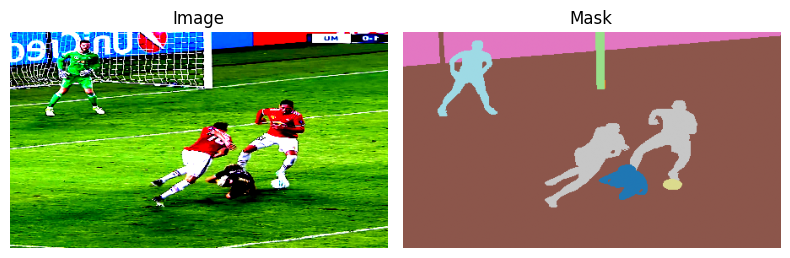

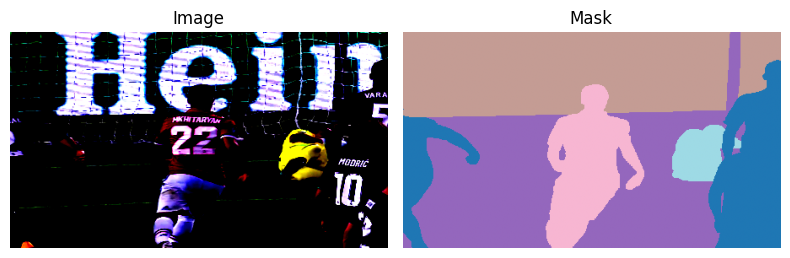

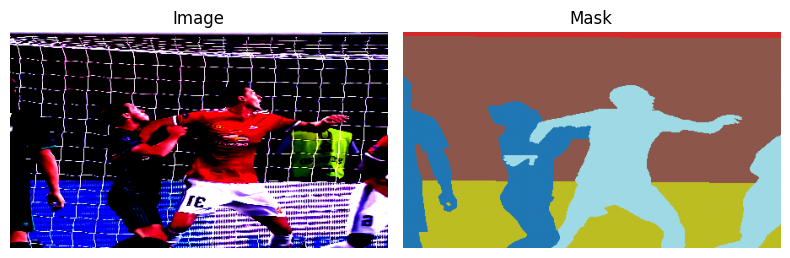

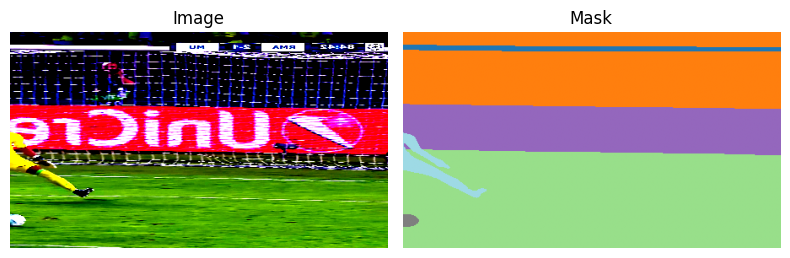

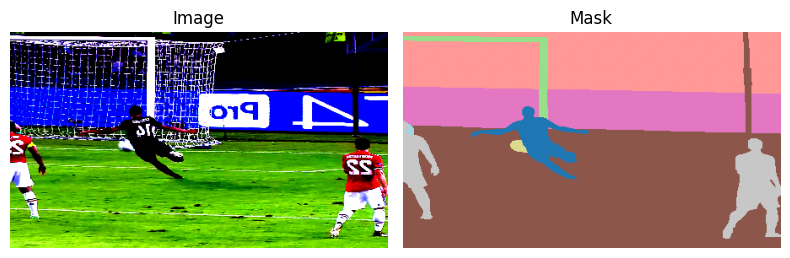

In [ ]:
# 증강된 이미지 잘 만들어졌는지 확인 (aug1)

for i in range(5):
    img , mask = train_aug1[i]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(img.permute(1,2,0))
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='tab20')  # mask는 grayscale
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

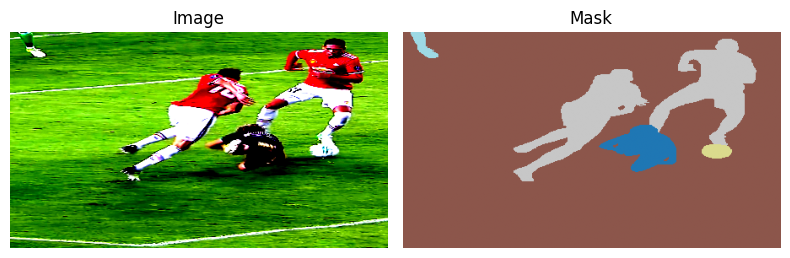

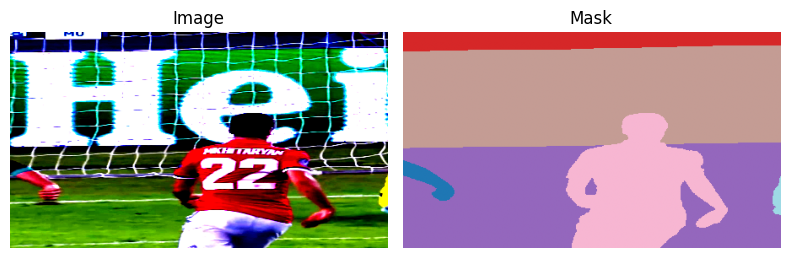

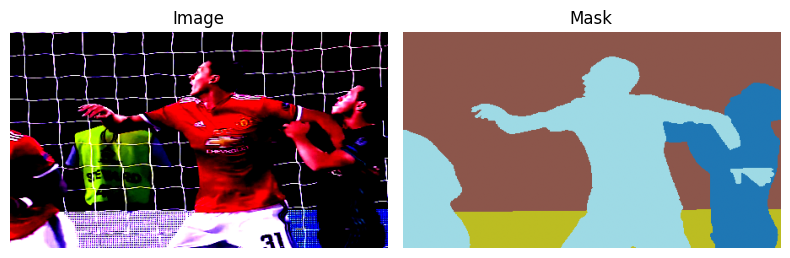

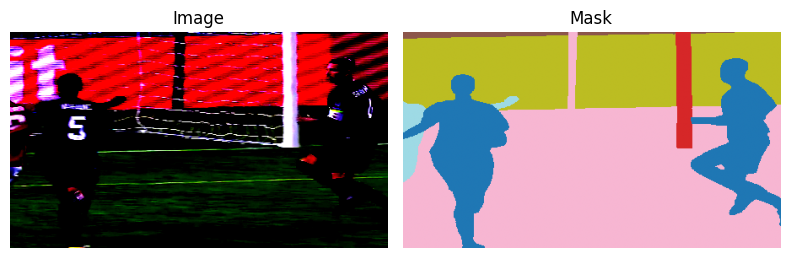

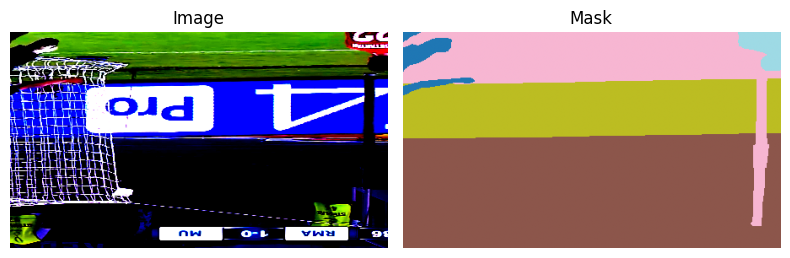

In [ ]:
# 증강된 이미지 잘 만들어졌는지 확인 (aug2)

for i in range(5):
    img , mask = train_aug2[i]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(img.permute(1,2,0))
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='tab20')  # mask는 grayscale
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Dataloader 생성 : final_train_dataset -> train_loader_aug

train_loader_aug = DataLoader(final_train_dataset, batch_size=10, shuffle=True,
                          worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [ ]:
# 같은 resnet34(U_net) 모델 생성후 증강된 train _ data 를 통해 성능 확인

import segmentation_models_pytorch as smp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_resnet34_aug = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",   # pretrained
    in_channels=3,
    classes=11
)

unet_resnet34_aug = unet_resnet34_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_resnet34_aug.parameters(), lr=0.0001) # 0.0001

In [ ]:
dice_loss_fn = DiceLoss()
num_epochs = 50

for epoch in range(num_epochs):
    unet_resnet34_aug.train()

    for imgs, masks in train_loader_aug:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = unet_resnet34_aug(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    unet_resnet34_aug.eval()
    total_mIoU, total_dice = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = unet_resnet34_aug(imgs)
            pred_labels = preds.argmax(dim=1)

            total_mIoU += compute_mIoU(pred_labels, masks, num_classes=11)
            total_dice += 1 - dice_loss_fn(preds, masks)

    print(f"[Epoch {epoch+1}] loss: {loss:.4f}, val_mIoU: {total_mIoU/len(val_loader):.4f}, val_Dice: {total_dice/len(val_loader):.4f}")

[Epoch 1] loss: 1.7476, val_mIoU: 0.1700, val_Dice: 0.1103
[Epoch 2] loss: 1.3830, val_mIoU: 0.2572, val_Dice: 0.1322
[Epoch 3] loss: 1.1003, val_mIoU: 0.3304, val_Dice: 0.1657
[Epoch 4] loss: 0.9588, val_mIoU: 0.3571, val_Dice: 0.1950
[Epoch 5] loss: 0.8228, val_mIoU: 0.3944, val_Dice: 0.2168
[Epoch 6] loss: 0.8346, val_mIoU: 0.4281, val_Dice: 0.2347
[Epoch 7] loss: 0.6300, val_mIoU: 0.4557, val_Dice: 0.2486
[Epoch 8] loss: 0.6864, val_mIoU: 0.4486, val_Dice: 0.2625
[Epoch 9] loss: 0.5763, val_mIoU: 0.4600, val_Dice: 0.2804
[Epoch 10] loss: 0.4534, val_mIoU: 0.4590, val_Dice: 0.2947
[Epoch 11] loss: 0.4003, val_mIoU: 0.4399, val_Dice: 0.3077
[Epoch 12] loss: 0.3676, val_mIoU: 0.4429, val_Dice: 0.3108
[Epoch 13] loss: 0.3753, val_mIoU: 0.4565, val_Dice: 0.3264
[Epoch 14] loss: 0.3558, val_mIoU: 0.4596, val_Dice: 0.3374
[Epoch 15] loss: 0.3155, val_mIoU: 0.4715, val_Dice: 0.3410
[Epoch 16] loss: 0.2764, val_mIoU: 0.4630, val_Dice: 0.3462
[Epoch 17] loss: 0.3519, val_mIoU: 0.4966, val_Di

In [ ]:
visualize_all_predictions(unet_resnet34_aug, val_dataset, device=device)

## train_dataloder vs train_dataloder_aug

- 같은 pretrained_resnet34(u_net) 모델 사용
- train_dataloader : [Epoch 50] loss: 0.1758, mIoU: 0.4730, Dice: 0.3511
- train_dataloader_aug : [Epoch 50] loss: 0.1102, val_mIoU: 0.6559, val_Dice: 0.4646
- 증강한 데이터를 학습시킨 모델이 훨씬 더 빠른 학습 속도를 보여줌
- 훨씬 더 이미지의 디테일한 부분을 더 잘 예측함

## 모델 시각화

## U-net 직접 구성
- 가중치 초기화 (He Initialization) 적용
- 파라미터 수정 (학습률 0.0001 -> 0.0002 , weight_decay=1e-4 )
- crop 없이 padding=1을 사용해서 feataure map 크기를 맞추는 구조로 작성

- Encoder

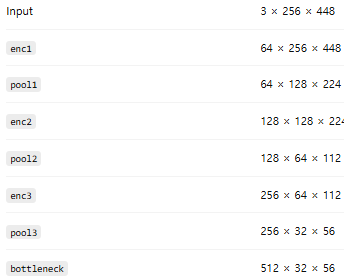

- Decoder

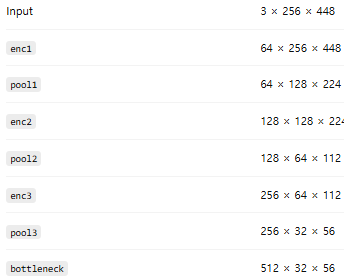

## 가중치 초기화
- He Initialization(= Kaiming Initialization)
- ReLU 계열에 특화된 가중치 초기화 방법

In [ ]:
def _init_weights(m):
    """Initialize weights of the model."""
    if isinstance(m, nn.Conv2d):
        # Use He initialization (kaiming normal)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.ConvTranspose2d):
        # Use He initialization (kaiming normal) for transposed convolutions
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        # Initialize BatchNorm weights
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        # Initialize fully connected layers (linear layers)
        nn.init.xavier_normal_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
# Double convolution Block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
# U-Net with bottleneck 512

class UNet_512(nn.Module):
    def __init__(self, in_channels=3, out_channels=11):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(256, 512)  #  bottleneck 채널수 512

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        orig_size = x.shape[2:]  # 입력 해상도 저장

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Bottleneck
        b = self.bottleneck(self.pool3(e3))

        # Decoder
        d3 = self.upconv3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)

        return out

In [ ]:
# U-Net Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet_512 = UNet_512(in_channels=3, out_channels=11)
model_unet_512.apply(_init_weights)
model_unet_512 = model_unet_512.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_unet_512.parameters(), lr=0.0002, weight_decay=1e-4)

In [ ]:
dice_loss_fn = DiceLoss()
num_epochs = 50

for epoch in range(num_epochs):
    model_unet_512.train()

    for imgs, masks in train_loader_aug:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model_unet_512(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model_unet_512.eval()
    total_mIoU, total_dice = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model_unet_512(imgs)
            pred_labels = preds.argmax(dim=1)

            total_mIoU += compute_mIoU(pred_labels, masks, num_classes=11)
            total_dice += 1 - dice_loss_fn(preds, masks)

    print(f"[Epoch {epoch+1}] loss: {loss:.4f}, val_mIoU: {total_mIoU/len(val_loader):.4f}, val_Dice: {total_dice/len(val_loader):.4f}")

[Epoch 1] loss: 0.8791, val_mIoU: 0.2507, val_Dice: 0.2072
[Epoch 2] loss: 0.7178, val_mIoU: 0.3277, val_Dice: 0.2702
[Epoch 3] loss: 0.5233, val_mIoU: 0.3755, val_Dice: 0.2792
[Epoch 4] loss: 0.7913, val_mIoU: 0.3899, val_Dice: 0.3113
[Epoch 5] loss: 0.3510, val_mIoU: 0.4036, val_Dice: 0.3358
[Epoch 6] loss: 0.3635, val_mIoU: 0.4614, val_Dice: 0.3618
[Epoch 7] loss: 0.3689, val_mIoU: 0.4602, val_Dice: 0.3427
[Epoch 8] loss: 0.3807, val_mIoU: 0.4984, val_Dice: 0.3778
[Epoch 9] loss: 0.2489, val_mIoU: 0.5053, val_Dice: 0.3829
[Epoch 10] loss: 0.3092, val_mIoU: 0.5026, val_Dice: 0.3927
[Epoch 11] loss: 0.4038, val_mIoU: 0.5061, val_Dice: 0.3862
[Epoch 12] loss: 0.2879, val_mIoU: 0.5392, val_Dice: 0.4070
[Epoch 13] loss: 0.2449, val_mIoU: 0.5477, val_Dice: 0.4185
[Epoch 14] loss: 0.2002, val_mIoU: 0.5708, val_Dice: 0.4283
[Epoch 15] loss: 0.1911, val_mIoU: 0.5541, val_Dice: 0.4124
[Epoch 16] loss: 0.2138, val_mIoU: 0.5384, val_Dice: 0.4251
[Epoch 17] loss: 0.1738, val_mIoU: 0.5805, val_Di

In [ ]:
visualize_all_predictions(model_unet_512, val_dataset, device=device)

- 가중치 초기화를 사용한 결과 1 epoch 에서 다른 모델과 비교시 높은 val_mIou / val_dice 값을 얻을 수 있었음
- 전이 학습을 통해 만든 U_net 모델들 보다 학습속도가 빠르고 / 50 epcoh 기준 더 좋은 모델 성능을 확인할수 있었으나 파라미터값을 수정하고 가중치 초기화를 사용하였기 때문에 모델간 직접적인 성능 비교는 어려움
- 훨씬 더 이미지의 경계를 파악하고 분류하는 성능이 올라감을 val데이터를 이미지화 함으로써 확인할 수 있음 (image 0, 1, 2, 3, 4, 7, 8)
- 축구 공까지 정확하게 분류
- 다만 아직까지 클래스를 잘못 분류하는 이미지도 존재 (5, 6, 9)

## U_net 모델 구조 개선
- layer / skip connection 1층 더 추가

- Encoder

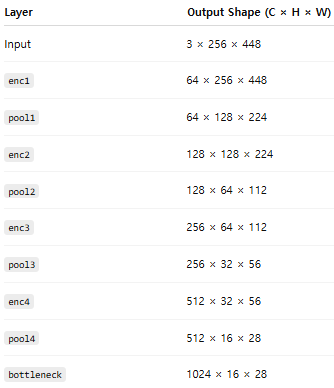

- Decoder

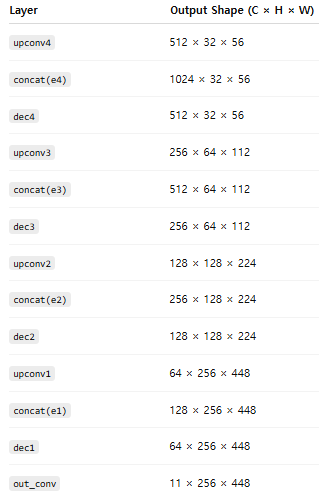

In [ ]:
# U-Net Model
class UNet_1024(nn.Module):
    def __init__(self, in_channels=3, out_channels=11):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        # Final output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with skip connections
        d4 = self.upconv4(b)
        d4 = self._crop_and_concat(e4, d4)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = self._crop_and_concat(e3, d3)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = self._crop_and_concat(e2, d2)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = self._crop_and_concat(e1, d1)
        d1 = self.dec1(d1)

        return self.out_conv(d1)

    def _crop_and_concat(self, enc_feat, dec_feat):
        # 자동으로 크기 맞춰주는 crop & concat (입력 크기 다르면 center crop)
        if enc_feat.shape[2:] != dec_feat.shape[2:]:
            enc_feat = self._center_crop(enc_feat, dec_feat.shape[2:])
        return torch.cat([enc_feat, dec_feat], dim=1)

    def _center_crop(self, feature_map, target_spatial):
        _, _, h, w = feature_map.shape
        target_h, target_w = target_spatial
        start_h = (h - target_h) // 2
        start_w = (w - target_w) // 2
        return feature_map[:, :, start_h:start_h + target_h, start_w:start_w + target_w]

In [ ]:
# U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_unet_1024 = UNet_1024(in_channels=3, out_channels=11)
model_unet_1024.apply(_init_weights)
model_unet_1024 = model_unet_1024.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_unet_1024.parameters(), lr=0.0002, weight_decay=1e-4)

In [ ]:
dice_loss_fn = DiceLoss()
num_epochs = 50

for epoch in range(num_epochs):
    model_unet_1024.train()

    for imgs, masks in train_loader_aug:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model_unet_1024(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model_unet_1024.eval()
    total_mIoU, total_dice = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model_unet_1024(imgs)
            pred_labels = preds.argmax(dim=1)

            total_mIoU += compute_mIoU(pred_labels, masks, num_classes=11)
            total_dice += 1 - dice_loss_fn(preds, masks)

    print(f"[Epoch {epoch+1}] loss: {loss:.4f}, val_mIoU: {total_mIoU/len(val_loader):.4f}, val_Dice: {total_dice/len(val_loader):.4f}")

[Epoch 1] loss: 0.7816, val_mIoU: 0.2276, val_Dice: 0.1993
[Epoch 2] loss: 0.5461, val_mIoU: 0.3155, val_Dice: 0.2683
[Epoch 3] loss: 0.5176, val_mIoU: 0.3379, val_Dice: 0.2778
[Epoch 4] loss: 0.4757, val_mIoU: 0.3788, val_Dice: 0.3005
[Epoch 5] loss: 0.3272, val_mIoU: 0.4023, val_Dice: 0.3153
[Epoch 6] loss: 0.3695, val_mIoU: 0.4097, val_Dice: 0.3439
[Epoch 7] loss: 0.4461, val_mIoU: 0.4406, val_Dice: 0.3568
[Epoch 8] loss: 0.2902, val_mIoU: 0.4539, val_Dice: 0.3744
[Epoch 9] loss: 0.3249, val_mIoU: 0.4291, val_Dice: 0.3373
[Epoch 10] loss: 0.2899, val_mIoU: 0.4638, val_Dice: 0.3821
[Epoch 11] loss: 0.2904, val_mIoU: 0.4963, val_Dice: 0.3905
[Epoch 12] loss: 0.4038, val_mIoU: 0.5182, val_Dice: 0.3999
[Epoch 13] loss: 0.2363, val_mIoU: 0.5246, val_Dice: 0.4085
[Epoch 14] loss: 0.1916, val_mIoU: 0.5234, val_Dice: 0.4117
[Epoch 15] loss: 0.1904, val_mIoU: 0.5159, val_Dice: 0.4083
[Epoch 16] loss: 0.2512, val_mIoU: 0.5424, val_Dice: 0.4188
[Epoch 17] loss: 0.2324, val_mIoU: 0.4316, val_Di

In [ ]:
visualize_all_predictions(model_unet_1024, val_dataset, device=device)

## model_unet_512 vs model_unet_1024
- model_unet_512 : [Epoch 50] loss: 0.1048, val_mIoU: 0.7140, val_Dice: 0.5124
- model_unet_1024 : [Epoch 49] loss: 0.1653, val_mIoU: 0.6882, val_Dice: 0.5072
- 50 epcoh을 기준으로 model_unet_512가 더 빠른 학습속도와 더 좋은 모델 성능을 보여 주었다

## Dice Loss + Cross Entropy

- Cross Entropy Loss만 사용하는 대신, Dice Loss와 Cross Entropy를 결합한 손실 함수로 gradient를 업데이트

- Cross Entropy로 픽셀 단위 정확도를 유지하면서도 Dice 계수를 통해 공간적인 일관성을 반영하기 때문에, 전체적으로 학습 손실이 더 안정적으로 줄어들것으로 기대

- DiceLoss 0.5 / CrossEntropyLoss 0.5 비율로 사용

- 모델은 UNet_512 사용

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dice_cross = UNet_512(in_channels=3, out_channels=11)
model_dice_cross.apply(_init_weights)
model_dice_cross = model_dice_cross.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dice_cross.parameters(), lr=0.0002, weight_decay=1e-4)

In [ ]:
alpha = 0.5  # 가중치: CrossEntropy 0.5, Dice 0.5
dice_loss_fn = DiceLoss()
criterion_ce = nn.CrossEntropyLoss()

num_epochs = 50

for epoch in range(num_epochs):
    model_dice_cross.train()

    for imgs, masks in train_loader_aug:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model_dice_cross(imgs)

        loss_ce = criterion_ce(preds, masks)
        loss_dice = dice_loss_fn(preds, masks)
        loss = alpha * loss_ce + (1 - alpha) * loss_dice

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model_dice_cross.eval()
    total_mIoU, total_dice = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model_dice_cross(imgs)
            pred_labels = preds.argmax(dim=1)

            total_mIoU += compute_mIoU(pred_labels, masks, num_classes=11)
            total_dice += 1 - dice_loss_fn(preds, masks)

    print(f"[Epoch {epoch+1}] loss: {loss:.4f}, val_mIoU: {total_mIoU/len(val_loader):.4f}, val_Dice: {total_dice/len(val_loader):.4f}")

[Epoch 1] loss: 0.7590, val_mIoU: 0.2584, val_Dice: 0.2303
[Epoch 2] loss: 0.6813, val_mIoU: 0.3114, val_Dice: 0.2765
[Epoch 3] loss: 0.6162, val_mIoU: 0.3936, val_Dice: 0.3386
[Epoch 4] loss: 0.5185, val_mIoU: 0.4389, val_Dice: 0.3547
[Epoch 5] loss: 0.4717, val_mIoU: 0.4826, val_Dice: 0.3747
[Epoch 6] loss: 0.4796, val_mIoU: 0.5127, val_Dice: 0.4017
[Epoch 7] loss: 0.4331, val_mIoU: 0.5257, val_Dice: 0.4087
[Epoch 8] loss: 0.4195, val_mIoU: 0.5274, val_Dice: 0.4247
[Epoch 9] loss: 0.4269, val_mIoU: 0.5329, val_Dice: 0.4213
[Epoch 10] loss: 0.4672, val_mIoU: 0.5341, val_Dice: 0.4234
[Epoch 11] loss: 0.3843, val_mIoU: 0.5956, val_Dice: 0.4631
[Epoch 12] loss: 0.3685, val_mIoU: 0.5614, val_Dice: 0.4449
[Epoch 13] loss: 0.3445, val_mIoU: 0.5908, val_Dice: 0.4727
[Epoch 14] loss: 0.5106, val_mIoU: 0.5877, val_Dice: 0.4705
[Epoch 15] loss: 0.4286, val_mIoU: 0.6004, val_Dice: 0.4683
[Epoch 16] loss: 0.4269, val_mIoU: 0.6384, val_Dice: 0.4794
[Epoch 17] loss: 0.3864, val_mIoU: 0.6395, val_Di

In [ ]:
visualize_all_predictions(model_dice_cross, val_dataset, device=device)

## CrossEntropyLoss vs Dice Loss + Cross Entropy
- CrossEntropyLoss : [Epoch 50] loss: 0.1048, val_mIoU: 0.7140, val_Dice: 0.5124
- Dice Loss + Cross Entropy : [Epoch 47] loss: 0.2814, val_mIoU: 0.7350, val_Dice: 0.5333
- Dice Loss + Cross Entropy 사용시 학습 속도가 더 빨랐고 더 높은 val_mIoU / val_Dice 기록

## 느낀점 및 소감

- train 이미지의 개수가 적은 경우 단순한 이미지 증강만으로 큰 효과를 볼수 있을까 의문이 있었고, train_image를 train_image + train_image(aug1) + train_image(aug2) 로 늘린 부분이 개인적으로 좋았던 부분이라고 생각합니다

- 특히 RandomResizedCrop을 통해서 0.4 ~ 0.6배 이미지 크기 / 0.2 ~ 0.3배 이미지 크기를 확대한 데이터를 추가로 넣어서 학습 데이터의 수를 3배로 늘렸던 점이 공이라던가 선수A,B/심판 등의 classification 성능에 영향을 주었다고 생각합니다

- train_data 수가 적을때 항상 고민이 되는건 val_data 와 test_data를 구분지어서 나누어 주어야 하는가? 하는 부분이었습니다.

- test_data의 조건이 test_data의 이미지는 어떠한 방법으로든(ex:증강) 학습에 활용되지 않아야 한다는 조건으로 알고 있는데 val_data를 test_data와 같은 조건으로 만들어 둔다면 학습 에폭마다 data의 성능이나 과적합 등을 판단할수 있으며 최종적으로 모델의 성능 평가에도 활용가능하지 않을까? 하는게 이번 미션을 수행하며 했던 생각인데 그래도 test_data 까지 split을 해야하는가? 하는 부분에서 의문점이 남았습니다.

- 가중치 초기화의 경우 초기 에폭 단계에서 학습 속도를 높여주는 것을 알 수 있었지만 과연 많은 에폭을 통한 모델의 최고 성능 지표에도 영향을 줄 수 있는지 의문점이 들었습니다.

- 모델의 파라미터를 업데이트할때 사용할 loss 값을 여러 지표와 지표별 가중치를 이용해 업데이트 하는것이 유의미한 실험임을 알 수 있었습니다

### 멘토의견

데이터 전처리부터 전이학습, 증강 기법, 커스텀 U-Net 설계에 이르기까지 실험 전반을 매우 체계적이고 창의적으로 구성하셨습니다.  특히 증강 데이터를 3배로 늘려 mIoU가 눈에 띄게 향상된 부분과, RandomResizedCrop으로 작은 객체까지 잘 학습한 아이디어가 돋보였습니다. 다양한 백본(resnet34, efficientnet-b3) 비교 실험과 Dice/mIoU 지표를 함께 활용해 분할 품질을 다각도로 검증한 점도 돋보입니다. 커스텀 U-Net을 직접 구현하고 He 초기화까지 적용해 빠른 수렴 속도를 달성한 부분도 인상적이었습니다. 짧은 시간 내에 다양한 실험을 잘 정리해주셨습니다. 수고많으셨습니다 :)
